# Data Augmentation

**Data Augmentation** is a technique to artificially increase the size of training set by generating many realistic variants of each training instance.  
This can be seen as a regularization technique given that it's useful to reduce overfitting. The generated instances should be as realistic as possible: ideally, given an image from an augmented training set, a human should not be able to tell whether it was augmented or not.    
<br />
For example, you can slightly shift, rotate and resize every picture in the training set by variuos amount and add the resulting picture to the training set. This force the model to be more tolerant to variations in the position, orientation and size of the objects in the pictures. You can similarly generate many images with various contrasts. In general you can also flip the picture horizontally (except for asymmetrical objects).  
<br />
By combining these transformations, you can greatly increase the size of your training set. In this notebook we are going to create an augmented training set using the ImgAug library increasing the training set size by a scale factor of 7.  
These are the augmenters we'll use:  
<br />

  * **Fliplr** : flip/mirror input images horizontally
  * **Rotate Right**
  * **Rotate Left**
  * **Multiply** : let the image brighter or darker
  * **Contrast**
  * **Blur** 

In [61]:
import glob, cv2, os, shutil, random
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
from zipfile import ZipFile
from imageio import imread

In [62]:
#Mounting the Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [63]:
#Unzipping the Train Dataset
train_path = "/content/drive/MyDrive/Age_Detection_Project/Data/Train.zip"

with ZipFile(train_path, 'r') as myzip:
    myzip.extractall('/content/Train')
    print('Done unzipping Train.zip')

Done unzipping Train.zip


In [64]:
#Function to load a dataset
def load_dataset(path, folder_name, img_size=None):
    images = []
    images_path = glob.glob('..'+ path + '{}/*.jpg'.format(str(folder_name)))
    for img_path in images_path:
        img = cv2.imread(img_path)
        if img_size != None:
          img = cv2.resize(img, dsize=(img_size, img_size))
        images.append(img)   
    return images  

In [65]:
#Defining all the function to perform data augmentation
def flipping(images):
    #1. --------- Flipping Augmentation ---------
    flipping_augmentation = iaa.Fliplr(1)
    flipped_images = flipping_augmentation(images=images)
    return flipped_images

def rotate_left(images):
    #2. --------- Rotating Left Augmentation ---------
    rotate_left_augmentation = iaa.Affine(translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
                                          rotate=(-30, -5),
                                          scale=(0.5, 1.5))
    rotate_left_images = rotate_left_augmentation(images=images)
    return rotate_left_images

def rotate_right(images):
    #3. --------- Rotating Right Augmentation ---------
    rotate_right_augmentation = iaa.Affine(translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
                                           rotate=(5, 30),
                                           scale=(0.5, 1.5))
    rotate_right_images = rotate_right_augmentation(images=images)
    return rotate_right_images

def multiply_images(images):
    #4. --------- Multiply --------- (to let the image brighter or darker)
    multiply_augmentation = iaa.Multiply((0.5, 1.4)) 
    multiply_images = multiply_augmentation(images=images)
    return multiply_images

def contrast(images):
    #5. --------- Contrast ---------
    contrast_augmentation = iaa.LinearContrast((1.6, 2.4))
    contrast_images = contrast_augmentation(images=images)
    return contrast_images

def blur(images):
    #6. --------- Blur ---------
    blur_augmentation = iaa.GaussianBlur((0.5, 1.5))
    blur_images = blur_augmentation(images=images)
    return blur_images

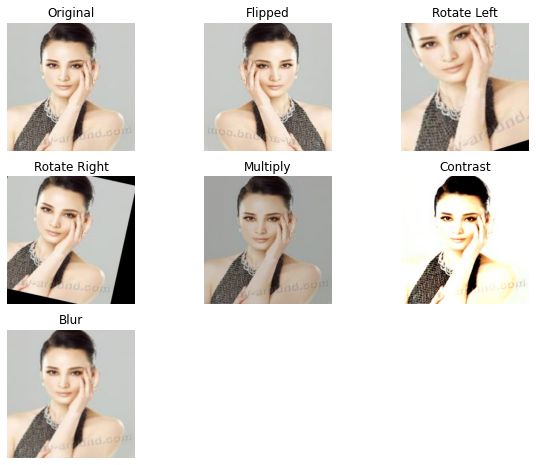

In [66]:
#Function for showing augmented images
def plot_aug(folder, n_class, n_img):
    #folder = folder containing all ther subfolder with all the images
    #n_class = subfolder name containing images of the corresponding class
    #n_img = image to visualize
    images = []
    images.append(folder + '/{}/{}.jpg'.format(n_class, n_img))
    
    count = 0
    for image in os.listdir(folder + '/{}'.format(n_class)):
      count += 1
    val = int(count/7)

    for n in range(6):
      images.append(folder + '/{}/{}.jpg'.format(n_class, val+n))  

    plt.figure(1, figsize=(10, 8))
    plt.axis('off')
    n = 0
    titles = ['Original', 'Flipped', 'Rotate Left', 'Rotate Right', 'Multiply', 'Contrast', 'Blur']
    for i in range(7):
      n += 1
      imgs = imread(images[i])
      plt.subplot(3, 3, n)
      plt.title(titles[i])
      plt.axis('off')
      plt.imshow(imgs)

    plt.show()

#Calling the plot_aug function choosing the first image of the class 3
aug_folder = '../content/Train_Augmented'
plot_aug(aug_folder, 3, 0)

In [67]:
#Creating the folder for the augmented data
dirpath = "/content/Train_Augmented/" 

if not os.path.exists("Train_Augmented"):
    os.mkdir("Train_Augmented")

In [68]:
#Creating the augmented images and putting them in the proper subfolder
img_size = 224
for num in range(8): 
    if not os.path.exists("Train_Augmented/" + str(num)):
        os.mkdir('Train_Augmented/'+ str(num))
    path = dirpath + str(num)
    images = load_dataset('/content/Train/', str(num), img_size)
    tot_imgs = images
    print('---- START IMAGES PROCESSING CLASS {} ----'.format(num))
    for n in range(len(images)):
        if n % 500 == 0:
            print('{} images processed of {}'.format(n, len(images)))
        flp = flipping([images[n]])
        rot_left = rotate_left([images[n]])
        rot_right = rotate_right([images[n]])
        mult = multiply_images([images[n]])
        contr = contrast([images[n]])
        blr = blur([images[n]])
        aug_img = [flp, rot_left, rot_right, mult, contr, blr]
        tot_imgs = tot_imgs + aug_img
    print('{} images processed of {}'.format(n+1, len(images)))        
    print('Image processing for class {} completed\n'.format(num))    
    print('---- START AUGMENTED IMAGES PROCESS CLASS {} ----'.format(num))                 
    for index, img in enumerate(tot_imgs):
        if isinstance(img, list):
            img = img.pop()
        cv2.imwrite(path + '/{}.jpg'.format(index), img)
        if index % 4000 == 0:
          print('{} images created of {}'.format(index, len(tot_imgs)))
    print('{} images created of {}'.format(index+1, len(tot_imgs)))      
    print('Augmented images creation process for class {} completed\n'.format(num))

---- START IMAGES PROCESSING CLASS 0 ----
0 images processed of 6112
500 images processed of 6112
1000 images processed of 6112
1500 images processed of 6112
2000 images processed of 6112
2500 images processed of 6112
3000 images processed of 6112
3500 images processed of 6112
4000 images processed of 6112
4500 images processed of 6112
5000 images processed of 6112
5500 images processed of 6112
6000 images processed of 6112
6112 images processed of 6112
Image processing for class 0 completed

---- START AUGMENTED IMAGES PROCESS CLASS 0 ----
0 images created of 42784
4000 images created of 42784
8000 images created of 42784
12000 images created of 42784
16000 images created of 42784
20000 images created of 42784
24000 images created of 42784
28000 images created of 42784
32000 images created of 42784
36000 images created of 42784
40000 images created of 42784
42784 images created of 42784
Augmented images creation process for class 0 completed

---- START IMAGES PROCESSING CLASS 1 ----


In [69]:
#Saving the augmented images folder in the Google Drive
train_augment_filename = '../content/drive/MyDrive/Age_Detection_Project/Data/Train_Augmented'
shutil.make_archive(train_augment_filename, 'zip', dirpath)

'/content/drive/MyDrive/Age_Detection_Project/Data/Train_Augmented.zip'